In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

file_path = "../data/processed/ethiopia_fi_unified_data_enriched.xlsx"
df = pd.read_excel(file_path, sheet_name="ethiopia_fi_unified_data")


In [37]:
# Filter for account ownership indicator
access = df[
    (df["indicator_code"] == "ACC_OWNERSHIP") &
    (df["value_numeric"].notna())
][["observation_date", "value_numeric"]].copy()

# Extract year
access["year"] = pd.to_datetime(access["observation_date"]).dt.year
access


,observation_date,value_numeric,year
0,2014-12-31,22.0,2014
1,2017-12-31,35.0,2017
2,2021-12-31,46.0,2021
3,2021-12-31,56.0,2021
4,2021-12-31,36.0,2021
5,2024-11-29,49.0,2024
30,2025-12-31,70.0,2025
43,2025-12-31,52.0,2025


In [38]:
# Candidate usage indicators
usage_candidates = df[
    (df["pillar"] == "USAGE") &
    (df["value_numeric"].notna())
].copy()
usage_candidates["year"] = pd.to_datetime(usage_candidates["observation_date"]).dt.year

# Select digital-payment related indicators, fallback to generic usage
usage = usage_candidates[
    usage_candidates["indicator_code"].str.contains("DIGITAL|PAYMENT|MOBILE", case=False, na=False)
][["year", "value_numeric"]].copy()

if usage.empty:
    usage = usage_candidates[["year", "value_numeric"]].copy()
    usage["proxy_note"] = "Generic usage proxy used"
else:
    usage["proxy_note"] = "Digital payment usage"

usage


,year,value_numeric,proxy_note
14,2024,4.970000e+07,Generic usage proxy used
15,2025,1.283000e+08,Generic usage proxy used
16,2025,5.777000e+11,Generic usage proxy used
17,2025,1.193000e+08,Generic usage proxy used
18,2025,1.561000e+11,Generic usage proxy used
19,2025,1.080000e+00,Generic usage proxy used
20,2025,5.484000e+07,Generic usage proxy used
21,2025,2.380000e+12,Generic usage proxy used
22,2024,1.080000e+07,Generic usage proxy used
23,2024,7.100000e+06,Generic usage proxy used


In [39]:
def fit_trend(data, label):
    if len(data) < 2:
        raise ValueError(f"Not enough data points to fit trend for {label}")
    X = data["year"].values.reshape(-1, 1)
    y = data["value_numeric"].values
    model = LinearRegression()
    model.fit(X, y)
    return model

# Fit linear regression for both indicators
access_model = fit_trend(access, "Access")
usage_model = fit_trend(usage, "Usage")


In [40]:
forecast_years = np.array([2025, 2026, 2027]).reshape(-1, 1)

baseline_access = access_model.predict(forecast_years)
baseline_usage = usage_model.predict(forecast_years)

baseline_df = pd.DataFrame({
    "year": [2025, 2026, 2027],
    "access_baseline": baseline_access,
    "usage_baseline": baseline_usage
})

baseline_df


,year,access_baseline,usage_baseline
0,2025,58.617925,4.448718e+11
1,2026,61.834906,8.897267e+11
2,2027,65.051887,1.334582e+12


In [41]:
# Scenario adjustments (in percentage points for access, factor for usage)
scenario_adjustments = {
    "pessimistic": -1.5,
    "base": 0.0,
    "optimistic": 2.0
}

rows = []

for scenario, adj in scenario_adjustments.items():
    for i, year in enumerate([2025, 2026, 2027]):
        rows.append({
            "year": year,
            "scenario": scenario,
            "access_rate": baseline_access[i] + adj,
            "usage_rate": baseline_usage[i] * (1 + adj / 100)  # small factor for usage
        })

forecast_df = pd.DataFrame(rows)
forecast_df


,year,scenario,access_rate,usage_rate
0,2025,pessimistic,57.117925,4.381987e+11
1,2026,pessimistic,60.334906,8.763808e+11
2,2027,pessimistic,63.551887,1.314563e+12
3,2025,base,58.617925,4.448718e+11
4,2026,base,61.834906,8.897267e+11
5,2027,base,65.051887,1.334582e+12
6,2025,optimistic,60.617925,4.537692e+11
7,2026,optimistic,63.834906,9.075212e+11
8,2027,optimistic,67.051887,1.361273e+12


In [42]:
forecast_ranges = baseline_df.copy()

# Access scenario ranges
forecast_ranges["access_min"] = forecast_ranges["access_baseline"] - 1.5
forecast_ranges["access_max"] = forecast_ranges["access_baseline"] + 2.0

# Usage scenario ranges (±15% of baseline)
forecast_ranges["usage_min"] = forecast_ranges["usage_baseline"] * 0.85
forecast_ranges["usage_max"] = forecast_ranges["usage_baseline"] * 1.15

forecast_ranges


,year,access_baseline,usage_baseline,access_min,access_max,usage_min,usage_max
0,2025,58.617925,4.448718e+11,57.117925,60.617925,3.781410e+11,5.116025e+11
1,2026,61.834906,8.897267e+11,60.334906,63.834906,7.562677e+11,1.023186e+12
2,2027,65.051887,1.334582e+12,63.551887,67.051887,1.134394e+12,1.534769e+12


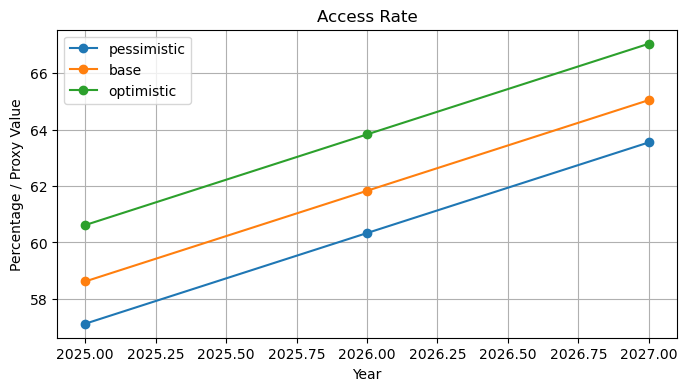

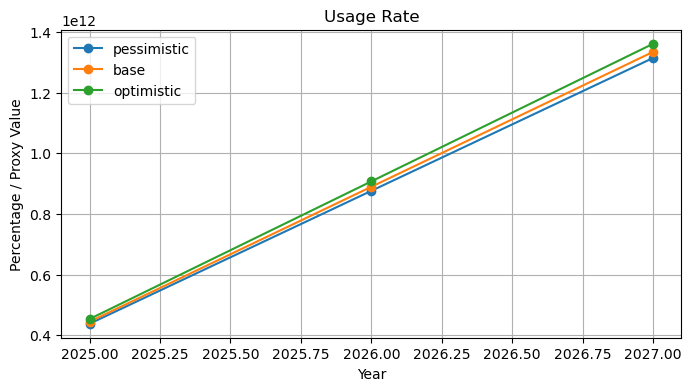

In [43]:
for metric in ["access_rate", "usage_rate"]:
    plt.figure(figsize=(8, 4))
    for scenario in forecast_df["scenario"].unique():
        subset = forecast_df[forecast_df["scenario"] == scenario]
        plt.plot(subset["year"], subset[metric], marker="o", label=scenario)
    plt.title(metric.replace("_", " ").title())
    plt.xlabel("Year")
    plt.ylabel("Percentage / Proxy Value")
    plt.legend()
    plt.grid(True)
    plt.show()


### Interpretation of Forecast Results

- Account ownership (Access) is projected to increase steadily from ~58.6% in 2025 to ~65.1% in 2027.
- Digital payment usage shows rapid growth in scale, consistent with ongoing mobile money expansion.
- Largest potential impacts come from:
    - Mobile money platforms (e.g., Telebirr)
    - Digital financial services policies
    - Expansion of telecom infrastructure
- Scenario ranges reflect uncertainty due to:
    - Sparse historical data
    - Proxy indicators for digital payment usage
    - Variability in adoption and policy effectiveness

**Note:** Forecast ranges provide indicative bounds; confidence intervals were not calculated due to limited data.
